In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from scipy import integrate
from scipy.optimize import curve_fit

In [ ]:
pip install gdown==v4.6.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


https://docs.google.com/spreadsheets/d/1sx0gy0Ku4yW__4lVbXBhPJ5HwORHL2_E/edit?usp=sharing&ouid=114253294372712711027&rtpof=true&sd=true

In [ ]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.0
    Uninstalling gdown-4.6.0:
      Successfully uninstalled gdown-4.6.0


In [ ]:
! gdown --id 1sx0gy0Ku4yW__4lVbXBhPJ5HwORHL2_E

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sx0gy0Ku4yW__4lVbXBhPJ5HwORHL2_E
To: /content/actual_data.xlsx
100% 244k/244k [00:00<00:00, 29.1MB/s]


In [ ]:
df = pd.read_excel('actual_data.xlsx')
second = np.array(df['min'])*60
df['hours'] = df['min']/60
REAL = np.array(df.iloc[1511, 2:59]).transpose()
df.head()

,min,day,A0('11-25'),A0('9-16' ),A0('9-10'),A0('9-20'),A0('9-24'),A0('9-27'),A0('9-11'),A0('11-28'),...,C('11-20'),C('11-04'),C(11-06'),C('10-28'),C('10-21'),C('11-13'),C('10-24'),C('10-30'),Surname,hours
0,0.0,0.000000,0.0073,0.0000,0.0061,0.0032,0.0107,0.0136,0.0142,0.0061,...,0.0038,0.0014,0.0013,0.0015,0.0008,0.0047,0.0009,0.0075,s1,0.000000
1,5.0,0.003472,0.0394,0.0709,0.0035,0.0029,0.0432,0.0332,0.0124,0.0021,...,0.0073,0.0019,0.0040,0.0008,0.0004,0.0091,0.0008,0.0046,s2,0.083333
2,10.0,0.006944,0.0744,0.1349,0.0092,0.0099,0.0819,0.0513,0.0044,0.0036,...,0.0161,0.0036,0.0094,0.0014,0.0006,0.0221,0.0014,0.0025,s3,0.166667
3,15.0,0.010417,0.0727,0.1605,0.0179,0.0243,0.1011,0.0599,0.0044,0.0075,...,0.0284,0.0071,0.0176,0.0024,0.0008,0.0383,0.0024,0.0064,s4,0.250000
4,20.0,0.013889,0.0685,0.1656,0.0416,0.0458,0.1104,0.0649,0.0047,0.0133,...,0.0434,0.0125,0.0279,0.0038,0.0011,0.0562,0.0039,0.0126,s5,0.333333


In [ ]:
7550/60/24

5.243055555555555

In [ ]:
df.iloc[:, 1]

0       0.000000
1       0.003472
2       0.006944
3       0.010417
4       0.013889
          ...   
1507    5.232639
1508    5.236111
1509    5.239583
1510    5.243056
1511         NaN
Name: day, Length: 1512, dtype: float64

In [ ]:
# Linear BOI and Q
def A_0(Q):
  x = (Q + 39.478)/9.862
  return x

def A_1(Q):
  x = (Q + 16.548)/7.9411
  return x

def B_0(Q):
  x = (Q + 41.036)/9.9758
  return x

def B_1(Q):
  x = (Q + 10.56)/7.9659
  return x

def C_0(Q):
  x = (Q + 30.168)/8.7912
  return x

def C_1(Q):
  x = (Q + 18.662)/7.3071
  return x


def renorm(New, Max, Min):
  return New*(Max-Min)+Min

def Renormalize(New, Max, Min):
  NewN = pd.DataFrame()
  for i in range(0, New.shape[1]-1):
    NewN[New.columns[i+1]] = renorm(New.iloc[:, i+1], Max[i], Min[i])
  return NewN

def normal(X):
  if X[25:].min() < 0.02:
    return (X-X[25:].min())/(X.max()-X[25:].min())
  else:
    return (X-0.02)/(X.max()-0.02)

def Normalize_time(k):
  Data = pd.DataFrame()
  for i in range(2, 59):
    Data[df.columns[i]] = normal(df.iloc[1:k, i])
  Max = []
  for i in range(2, 59):
    Max.append(df.iloc[1:k, i].max())
  Min = []
  for i in range(2, 59):
    if df.iloc[25:k, i].min() < 0.02:
      Min.append(df.iloc[25:k, i].min())
    else:
      Min.append(0.02)
  return (Data, Max, Min)

def left_rect(x, f):
  Q=[]
  SUM_Q = 0
  h = x[1]-x[0]
  for i in range(0, f.shape[0]):
    SUM_Q+=h*f[i]
    Q.append(SUM_Q)
  return Q

def BOI(Q_r, k=1):
  BOIA0 = [A_0(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(0, 9)]
  BOIB0 = [B_0(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(9, 18)]
  BOIC0 = [C_0(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(18, 27)]
  BOIA1 = [A_1(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(27, 37)]
  BOIB1 = [B_1(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(37, 47)]
  BOIC1 = [C_1(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(47, 57)]
  return BOIA0 + BOIB0 + BOIC0 + BOIA1 + BOIB1 + BOIC1

def MAPE(boi):
  MAPE_PRED = []
  for i in range(0, 57):
    MAPE_PRED.append(mean_absolute_percentage_error([REAL[i]], [boi[i]]))
  return MAPE_PRED

In [ ]:
def QQQ(s, _Data):
  Data = pd.DataFrame()
  Data['long'] = pd.Series([i for i in range(1511)])
  for i in range(_Data.shape[1]):
    Q = left_rect(s, _Data.iloc[:, i].values[:np.count_nonzero(~np.isnan(_Data.iloc[:, i].values))]/100)
    Data[_Data.columns[i]] = Q + [None] * (1511 - len(Q))

  Data.drop('long', axis=1, inplace=True)
  return Data

In [ ]:
def new_Normalize_time(k, _Data):
  Data = pd.DataFrame()
  Data['long'] = pd.Series([i for i in range(1511)])
  for i in range(_Data.shape[1]):
    Data[_Data.columns[i]] = normal(_Data.iloc[1:k[i], i])

  Max = []
  Min = []

  for i in range(_Data.shape[1]):
    Max.append(_Data.iloc[1:k[i], i].max())
    if _Data.iloc[25:k[i], i].min() < 0.02:
      Min.append(_Data.iloc[25:k[i], i].min())
    else:
      Min.append(0.02)
  Data.drop('long', axis=1, inplace=True)
  Data.drop(Data.index[0], axis=0, inplace=True)

  return (Data, Max, Min)

In [ ]:
B = df.iloc[:-1, 2:59]
indexes = B.fillna(0).apply(lambda x: x.loc[x.idxmax():][x <= x.max() / 1.75].idxmax()).tolist()
indexes = np.array(indexes)
indexes= np.where(indexes > 289, 289, indexes)
indexes= np.where(indexes < 49, 49, indexes)

In [ ]:
DataAll, MaxAll, MinAll = new_Normalize_time([-1 for i in range(df.iloc[:-1, 2:59].shape[1])], df.iloc[:-1, 2:59])
Data_new, Max_new, Min_new = new_Normalize_time(indexes, B)

In [ ]:
st = B.fillna(0).apply(lambda x: x.loc[:x.idxmax()][x <= x.max() / 1.2].idxmax()).tolist()
st = np.array(st)

st = np.where(st >= 289, 145, st)
maxes = np.array([df.iloc[:289, i+2].argmax() for i in range(57)])

In [ ]:
def f2(x, sigma, mu, a, b):
  return (np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))) - a/(b + np.exp(x))

def mnk2(T, date, param, lst1, lst2):
  popt, pcov = curve_fit(f2, date, T, param,  bounds=(lst1, lst2), method = 'trf')
  return popt

def new_Method(Data, k, s):
  New = pd.DataFrame()
  coeff = pd.DataFrame()
  New['long'] = df.iloc[1:-1, 1]
  for i in range(0, 57):
    if i > 26:
      param = (1.5, 0.5, 0.1, 0.5)
      lst1, lst2 = [0, -2.5, -2.5, 0.05], [2.5, 1.5, 0.6, 1.5]
    else:
      param = (1.5, 0.5, -0.1, 1)
      lst1, lst2 = [0, -0.3, -1, 0.8], [4, 3.5, 0.3, 1.2]
    sigma, mu, a, b = mnk2(Data.iloc[s[i]:Data.iloc[:k[i], i].count(), i], df.iloc[s[i]+1:Data.iloc[:k[i], i].count()+1, 1], param, lst1, lst2)
    coeff[Data.columns[i]] = sigma, mu, a, b
    New[Data.columns[i]] = f2(df.iloc[1:1300, 1], sigma, mu, a, b)
  return New, coeff

In [ ]:
def f2(x, sigma, mu, a, b):
  return (np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))) - a/(b + x**2)

def mnk2(T, date, param, lst1, lst2):
  popt, pcov = curve_fit(f2, date, T, param,  bounds=(lst1, lst2), method = 'trf')
  return popt

def new_Method(Data, k, s):
  New = pd.DataFrame()
  coeff = pd.DataFrame()
  New['long'] = df.iloc[1:-1, 1]
  for i in range(0, 57):
    if i > 26:
      param = (1.5, 0.5, 0.1, 0.5)
      lst1, lst2 = [0, -1.5, -1.5, 0.05], [1.9, 0.55, 0.15, 1.2]
    else:
      param = (1.5, 0.5, -0.1, 1)
      lst1, lst2 = [0, -0.3, -1, 0.8], [4, 3.5, 0.3, 1.2]
    sigma, mu, a, b = mnk2(Data.iloc[s[i]:Data.iloc[:k[i], i].count(), i], df.iloc[s[i]+1:Data.iloc[:k[i], i].count()+1, 1], param, lst1, lst2)
    coeff[Data.columns[i]] = sigma, mu, a, b
    New[Data.columns[i]] = f2(df.iloc[1:1300, 1], sigma, mu, a, b)
  return New, coeff

In [ ]:
NewAll, coeffAll = new_Method(DataAll, [-1 for i in range(DataAll.shape[1])], np.zeros(57).astype(int))
New_new, coeff_new = new_Method(Data_new, indexes, st)

NewNAll = Renormalize(NewAll, MaxAll, MinAll)
NewN_new = Renormalize(New_new, Max_new, Min_new)

NewNAll[NewNAll < 0] = 0
NewN_new[NewN_new < 0] = 0

In [ ]:
err = 0.0225

s_end = []
for j in range(27):
  if (maxes[j] < 96) or ((maxes[j] > 96) and (df.iloc[indexes[j], j+2] <= err)):
    if NewN_new.iloc[max(indexes[j]*2, 289):1300, j][NewN_new.iloc[max(indexes[j]*2, 289):1300, j] < err].empty == False:
      s_end.append(NewN_new.iloc[max(indexes[j]*2, 289):1300, j][NewN_new.iloc[max(indexes[j]*2, 289):1300, j] < err].index[0])
    else:
      s_end.append(1008)
  else:
    if (df.iloc[indexes[j], j+2] >= 0.03) and (df.iloc[indexes[j], j+2] <=0.04):
      s_end.append(1445)
    if (df.iloc[indexes[j], j+2] >= 0.045):
      s_end.append(795)

for j in range(27, 57):
  s_end.append(NewN_new.iloc[indexes[j]:1156, j].diff()[NewN_new.iloc[indexes[j]:1156, j].diff() <= -4e-05].index[-1])
s_end = np.array(s_end)
s_end[:27] = np.where(s_end[:27] <= 346, 346, s_end[:27])

In [ ]:
Ad = pd.DataFrame()
Ad['long'] = pd.Series([i for i in range(1511)])
for i in range(57):
  Ad[df.columns[i+2]] = [NewN_new.iloc[:s_end[i], i] for i in range(57)][i]
Ad.drop('long', axis=1, inplace=True)
Ad.drop(Ad.index[0], axis=0, inplace=True)


Q_real = QQQ(second[1:-1], Ad)
Q_realAll = QQQ(second[1:-1], df.iloc[:-1, 2:59])
Q_realAll = QQQ(second[:-1], df.iloc[:-1, 2:59])
Q_predAll = QQQ(second[1:-1], NewNAll)


boi_all_real = BOI(Q_realAll)
boi_all_pred = BOI(Q_predAll)
boi = BOI(Q_real, k=1)


pred = np.round(np.array(MAPE(boi))*100, 3)
real_mape = np.round(np.array(MAPE(boi_all_real))*100, 3)
pred_mape = np.round(np.array(MAPE(boi_all_pred))*100, 3)
r2 = r2_score(boi_all_real, boi)
max_err = max_error(boi_all_real, boi)
mae = mean_absolute_error(boi_all_real, boi)

print(real_mape.mean())
print('ALL ', pred_mape.mean())
print('newsssss ', pred.mean())
print("R^2 score:", r2)
print("Максимальная абсолютная ошибка:", max_err)
print("Средняя абсолютная ошибка:", mae)
print("Максимальная процентная ошибка:", pred.max())

5.4891228070175435
ALL  51.23945614035088
newsssss  6.777614035087719
R^2 score: 0.9822316795052236
Максимальная абсолютная ошибка: 3.591004597455658
Средняя абсолютная ошибка: 0.9987000361011585
Максимальная процентная ошибка: 19.807


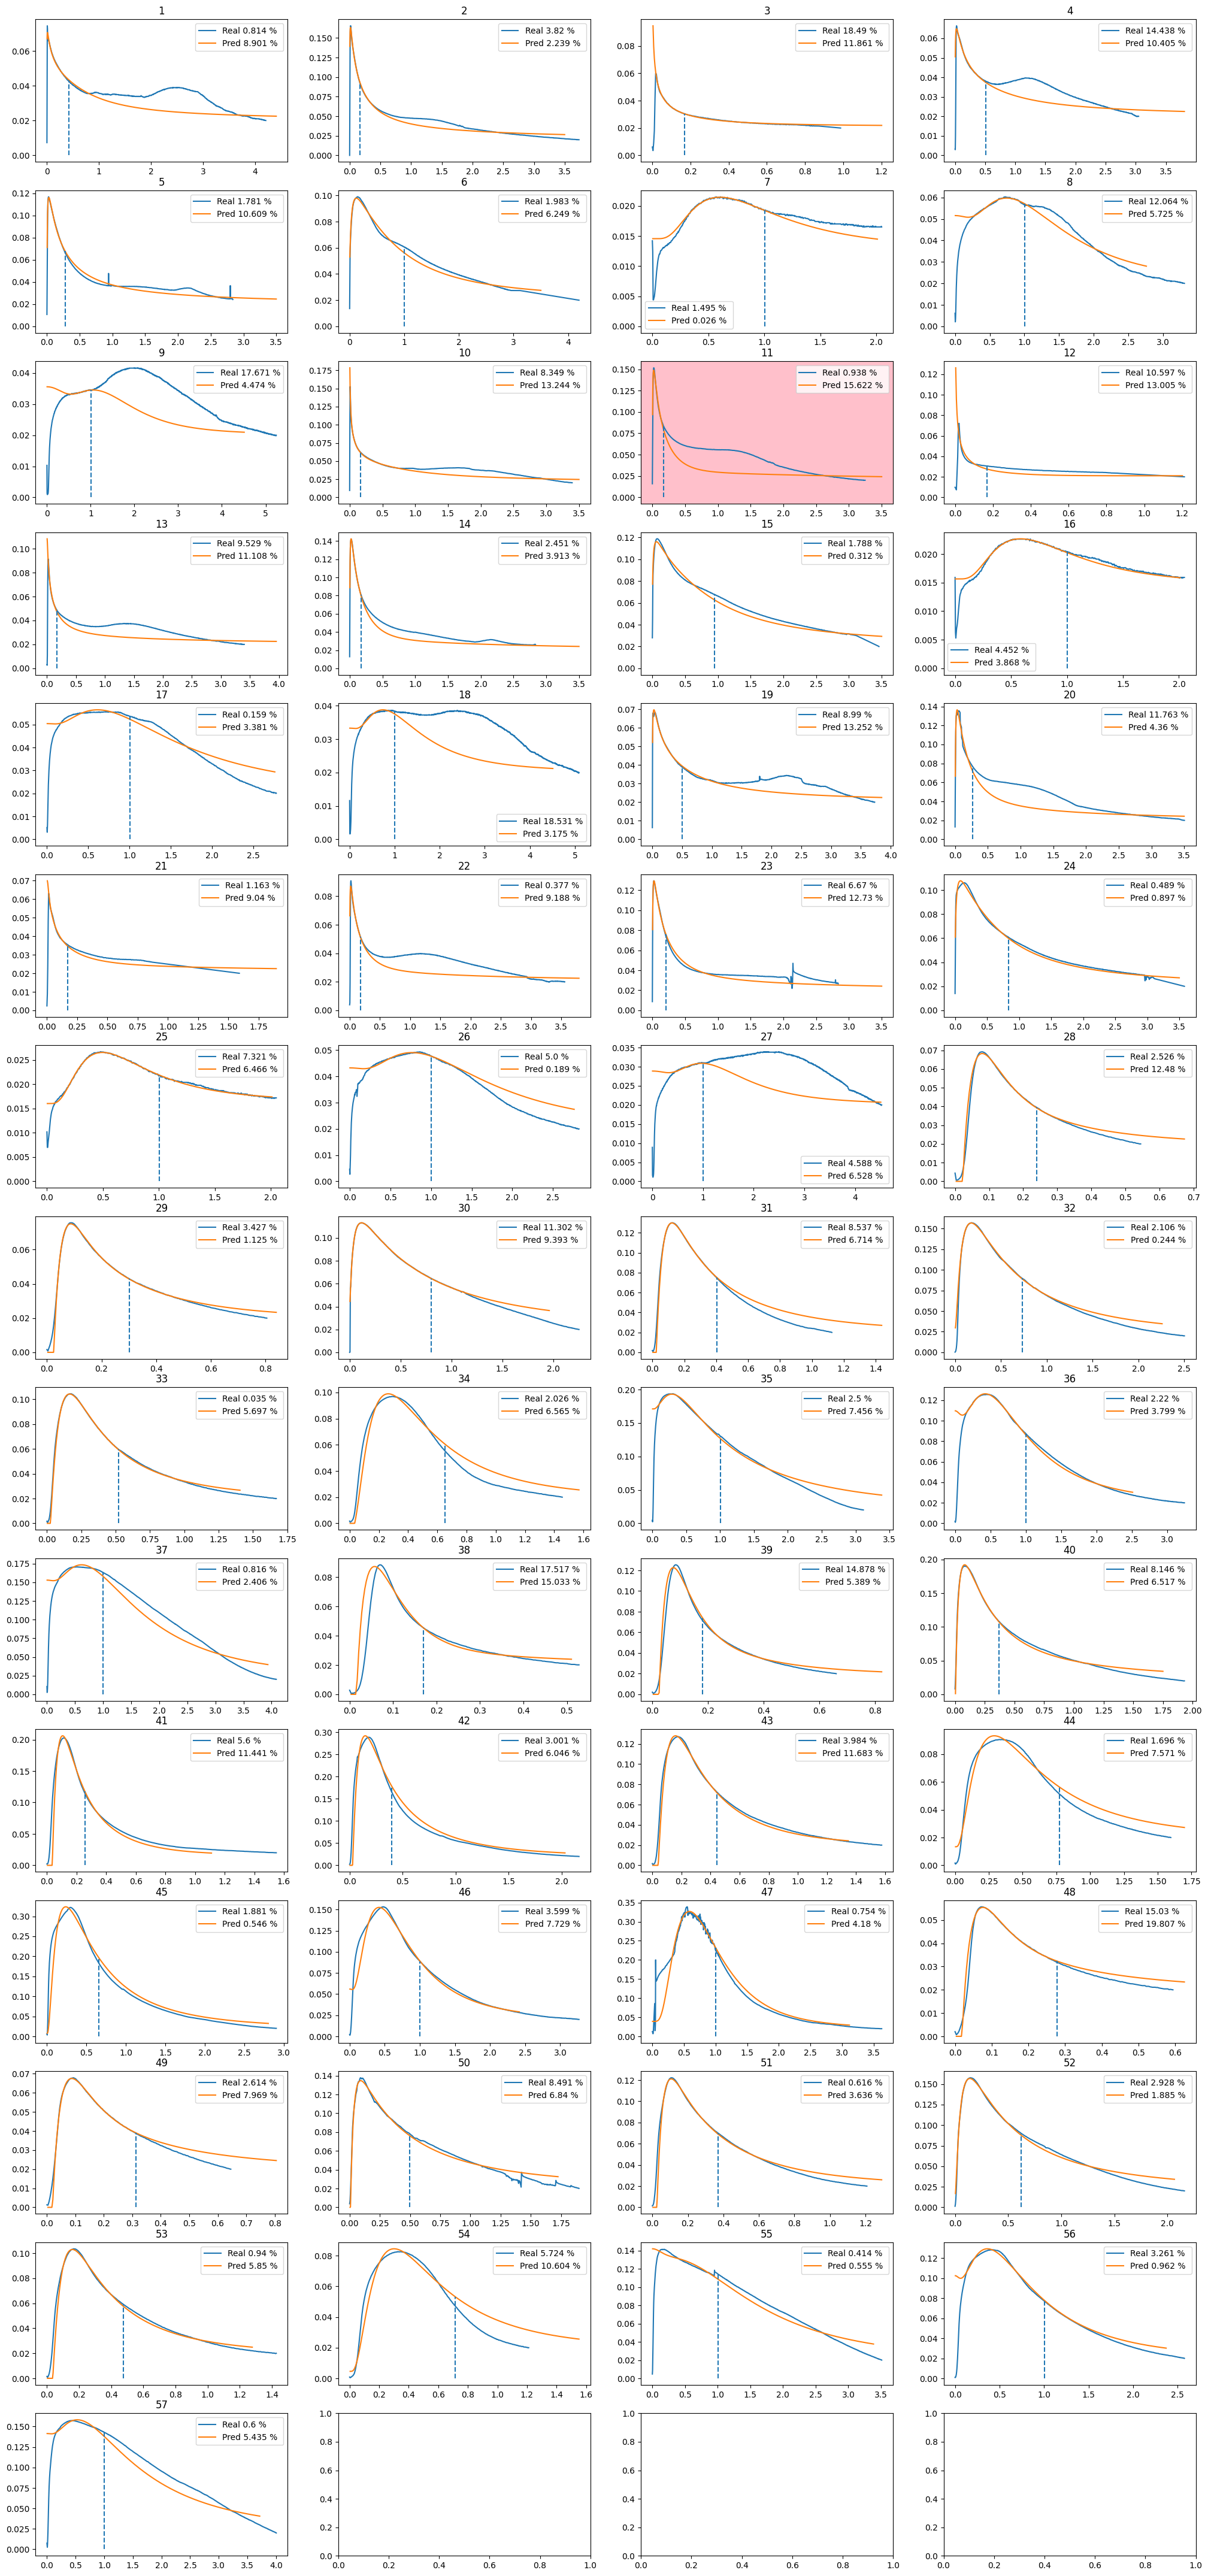

In [ ]:
fig, ax = plt.subplots(15, 4, figsize=(25, 55))
axs = [ax[i, j] for i in range(15) for j in range(4)]
for i in range(0, 57):
    if i in np.where(((pred - real_mape) > 10) == True)[0]:
      axs[i].set_facecolor('pink')
    axs[i].plot(df.iloc[:1511, 1], df.iloc[:1511, i+2], label = 'Real ' + str(real_mape[i]) + ' %')
    axs[i].plot(df.iloc[1:s_end[i] + 1, 1], NewN_new.iloc[:s_end[i], i], label = 'Pred ' + str(pred[i]) + ' % ')
    axs[i].set_title(str(i+1))
    axs[i].vlines(df.iloc[indexes[i], 1], 0, max(np.array(df.iloc[indexes[i], i+2]), np.array(NewN_new.iloc[indexes[i]-1, i])),  linestyle = '--')
    axs[i].legend()

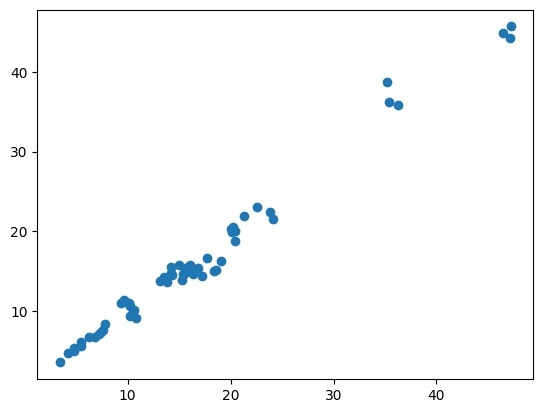

In [ ]:
plt.scatter(boi_all_real, boi)

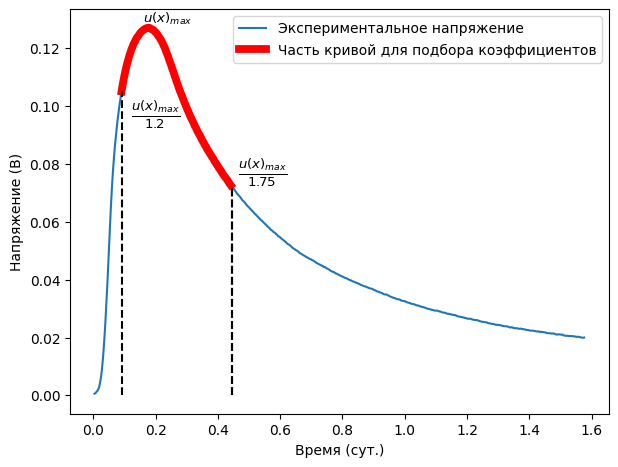

In [ ]:
k = -1
i = 42
plt.figure(figsize=(6.95, 5.25))
plt.plot(df.iloc[1:1511, 1], df.iloc[1:1511, i+2],  label = 'Экспериментальное напряжение')
plt.plot(df.iloc[st[i]:indexes[i], 1], df.iloc[st[i]:indexes[i], i+2], color='red', linewidth=5.6, label = 'Часть кривой для подбора коэффициентов')
plt.vlines(df.iloc[indexes[i], 1], 0, max(np.array(df.iloc[indexes[i], i+2]), np.array(NewN_new.iloc[indexes[i]-1, i])),  linestyle = '--', color='black')
plt.vlines(df.iloc[st[i], 1], 0, max(np.array(df.iloc[st[i], i+2]), np.array(NewN_new.iloc[st[i]-1, i])),  linestyle = '--', color='black')
plt.vlines(df.iloc[indexes[i], 1], 0, max(np.array(df.iloc[indexes[i], i+2]), np.array(NewN_new.iloc[indexes[i]-1, i])),  linestyle = '--' , color='black')
plt.text(0.1205, 0.095, r'$\frac{u(x)_{max}}{1.2}$', fontsize=13.6)
plt.text(0.465, 0.075, r'$\frac{u(x)_{max}}{1.75}$', fontsize=13.6)
plt.text(0.16, 0.1290, r'$u(x)_{max}$', fontsize=9.6)
plt.xlabel('Время (сут.)')
plt.ylabel('Напряжение (В)')
plt.legend()
plt.gcf().patch.set_facecolor('none')

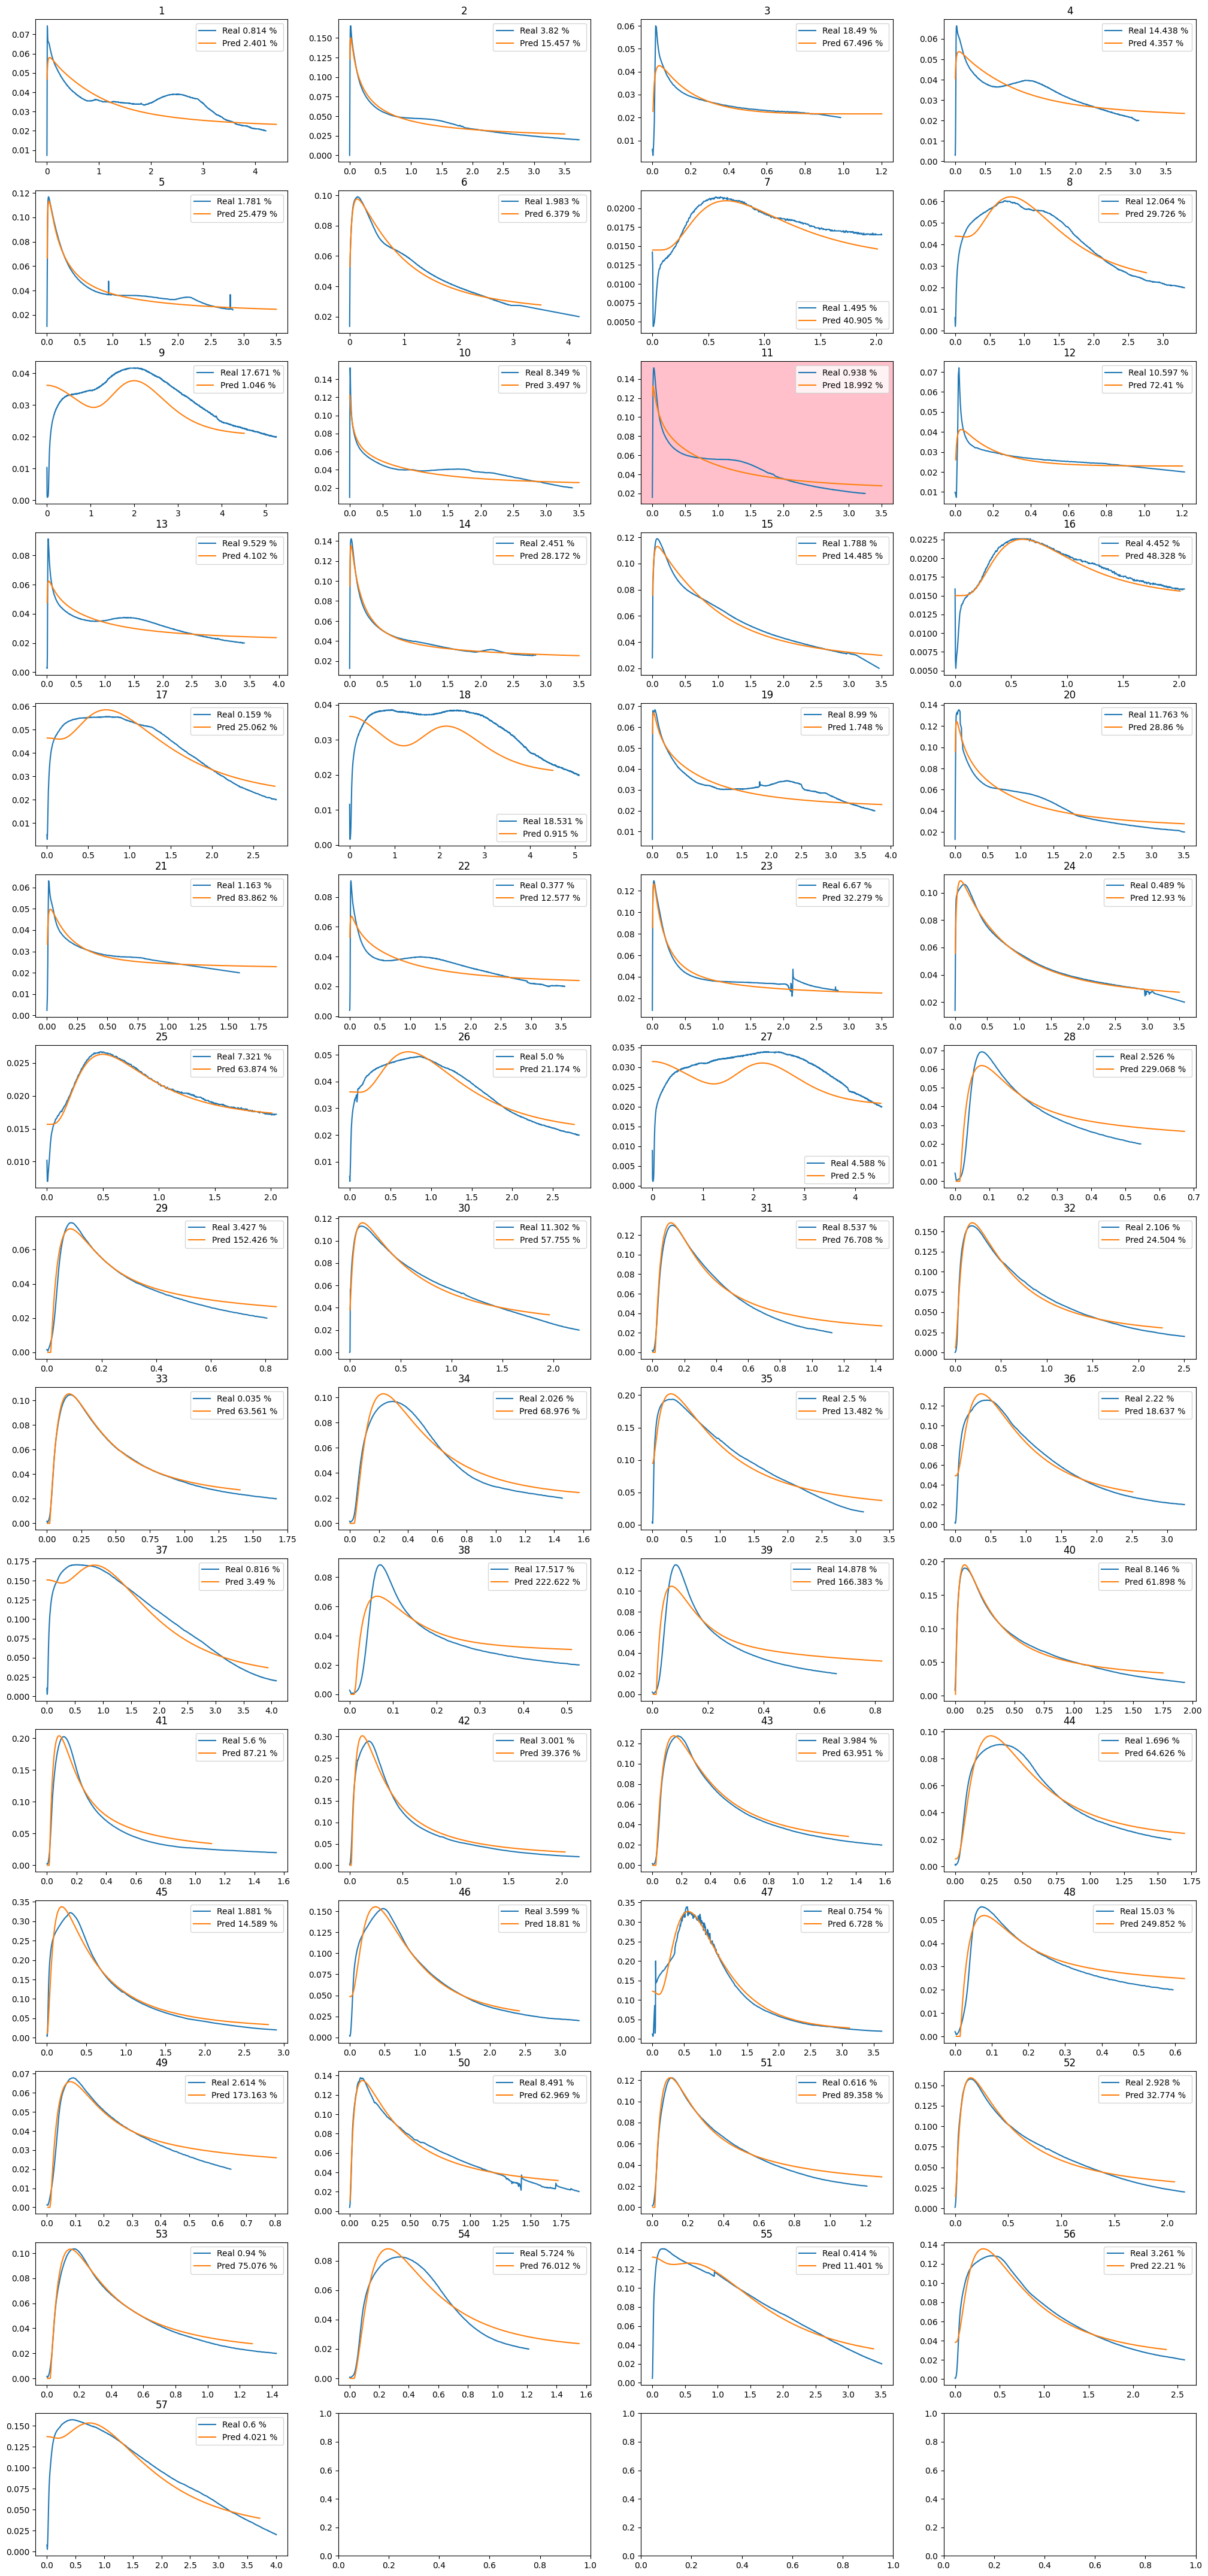

In [ ]:
fig, ax = plt.subplots(15, 4, figsize=(25, 55))
axs = [ax[i, j] for i in range(15) for j in range(4)]
for i in range(0, 57):
    if i in np.where(((pred - real_mape) > 10) == True)[0]:
      axs[i].set_facecolor('pink')
    axs[i].plot(df.iloc[:1511, 1], df.iloc[:1511, i+2], label = 'Real ' + str(real_mape[i]) + ' %')
    axs[i].plot(df.iloc[1:s_end[i] + 1, 1], NewNAll.iloc[:s_end[i], i], label = 'Pred ' + str(pred_mape[i]) + ' % ')
    axs[i].set_title(str(i+1))
    axs[i].legend()

In [ ]:
coeffAll.iloc[:, 42]

0    1.053252
1   -0.868111
2    0.150000
3    0.242950
Name: B('10-28'), dtype: float64

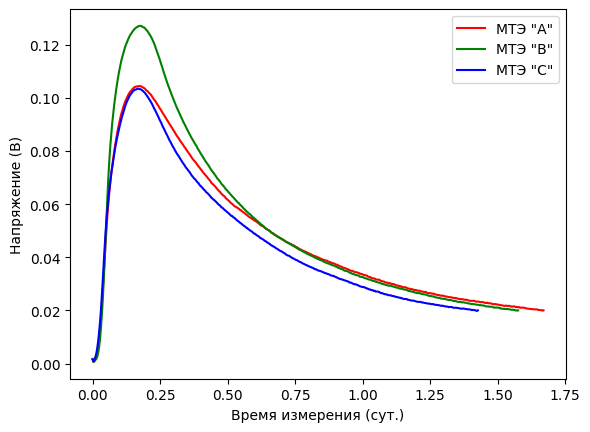

In [ ]:
i = 34
plt.plot(df.iloc[:-1, 1], df.iloc[:-1, i], color='red', label='МТЭ "A"')
plt.plot(df.iloc[:-1, 1], df.iloc[:-1, i+10], color='green', label='МТЭ "B"')
plt.plot(df.iloc[:-1, 1], df.iloc[:-1, i+20], color='blue', label='МТЭ "C"')
plt.xlabel('Время измерения (сут.)')
plt.ylabel('Напряжение (В)')
plt.legend()
plt.gcf().patch.set_facecolor('none')

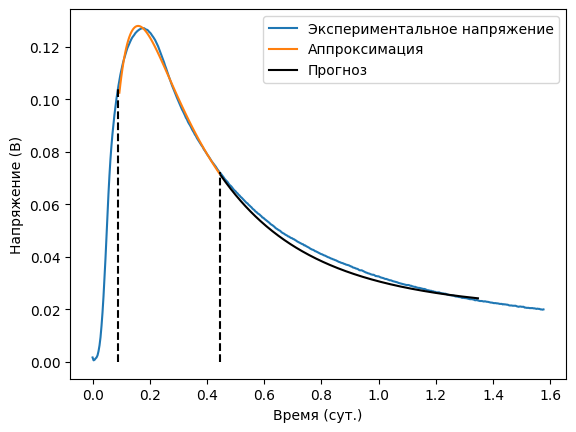

In [ ]:
i = 42

plt.plot(df.iloc[:1511, 1], df.iloc[:1511, i+2], label = 'Экспериментальное напряжение')
plt.plot(df.iloc[st[i]+1:indexes[i] + 1, 1], NewN_new.iloc[st[i]:indexes[i], i],  label = 'Аппроксимация')
plt.plot(df.iloc[indexes[i] + 1:s_end[i] + 1, 1], NewN_new.iloc[indexes[i]:s_end[i], i], color='black', label = 'Прогноз')
plt.vlines(df.iloc[indexes[i], 1], 0, max(np.array(df.iloc[indexes[i], i+2]), np.array(NewN_new.iloc[indexes[i]-1, i])),  linestyle = '--' , color='black')
plt.vlines(df.iloc[st[i], 1], 0, max(np.array(df.iloc[st[i], i+2]), np.array(NewN_new.iloc[st[i]-1, i])),  linestyle = '--', color='black')
plt.xlabel('Время (сут.)')
plt.ylabel('Напряжение (В)')
plt.legend()
plt.gcf().patch.set_facecolor('none')

In [ ]:
i = 4

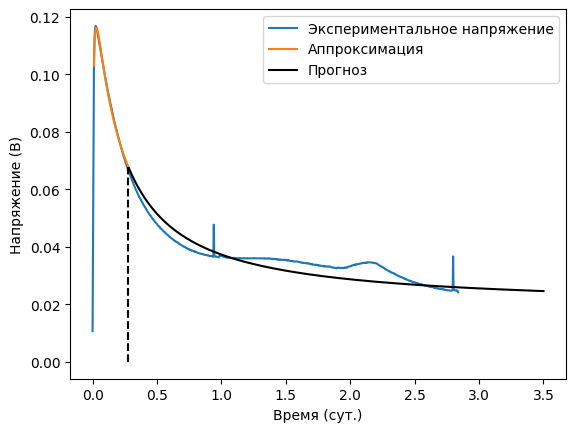

In [ ]:
plt.plot(df.iloc[:1511, 1], df.iloc[:1511, i+2], label = 'Экспериментальное напряжение')
plt.plot(df.iloc[st[i]+1:indexes[i] + 1, 1], NewN_new.iloc[st[i]:indexes[i], i],   label = 'Аппроксимация')
plt.plot(df.iloc[indexes[i] + 1:s_end[i] + 1, 1], NewN_new.iloc[indexes[i]:s_end[i], i], color='black',   label = 'Прогноз')
plt.vlines(df.iloc[indexes[i], 1], 0, max(np.array(df.iloc[indexes[i], i+2]), np.array(NewN_new.iloc[indexes[i]-1, i])), linestyle = '--',  color='black')
#plt.vlines(df.iloc[st[i], 1], 0, max(np.array(df.iloc[st[i], i+2]), np.array(NewN_new.iloc[st[i]-1, i])),  linestyle = '--', color='black')
plt.xlabel('Время (сут.)')
plt.ylabel('Напряжение (В)')
plt.legend()
plt.gcf().patch.set_facecolor('none')